##             Prediction de la valeur fonciere  à l'aide de model ElasticNet

Dans un model de regression Elastic Net, les coefficient de pénalisation est une combinaison linéaire des pénalités L1 et L2.

En d'autres termes la régression Elastic Net s'écrit :

- minβ1,…βp ∑(yi − ∑βj xij) 2+α(λ ∑||βj||+(1−λ)∑β2j)

Les avantages de cette combinaison sont principalement : 
- La conservation de la capacité de sélection de variables de LASSO avec exclusion des variables non pertinentes

- le partage des poids entre variables corrélées et pas de sélection arbitraire.

Sur scikit-learn, le terme  λ  est représenté par le paramètre l1_ration : 

- Un l1_ratio égal à 1 correspond donc à une régression Lasso,

- Un l1_ratio à 0 correspond à une régression Ridge.

Les autres valeurs comprises entre 0 et 1 correspondent à une combinaison des deux régularisations.

La fonction ElasticNetCV permet de trouver les meilleurs paramètres  λ  et  α  par validation croisée.

Tout comme LassoCV, elle renvoie une matrice des erreurs quadratiques moyennes obtenues, mais à 3 dimensions (une pour le  λ , une pour le  α  et une pour les différentes étapes de la validation croisée).

### 1- Importation des librairies et du fichier de données en csv

In [ ]:
#Importation des librairies et du fichier de données en csv:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns',None)


from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV, Ridge

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importation de base de données
path = '/content/drive/MyDrive/01-Abderaouf/IDF_2019_to_2021_v3.csv'
df = pd.read_csv(path)
# df = pd.read_csv('IDF_2019_to_2021_v3.csv')

### 2- Distrubution de la valeur fonciere et prix_m²

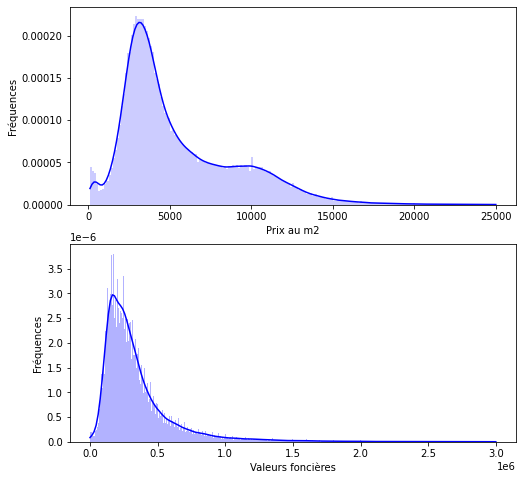

In [ ]:
# Distribution du prix au m2 et valeur fonciere 

plt.figure(figsize=(8,8))

plt.subplot(211)
sns.histplot(df['prix_m²'], stat='density', linewidth= 0, color = 'b', kde=True, alpha=0.2);
plt.xlabel("Prix au m2")
plt.ylabel("Fréquences");

plt.subplot(212)

sns.histplot(df['valeur_fonciere'], stat='density', linewidth=0, color = 'b', kde=True, alpha=0.3);
plt.xlabel("Valeurs foncières")
plt.ylabel("Fréquences");




### 3-a Remplacement des valeur manquante longitude latitude 
- Remplissage vers l'avant

- Remplissage arrière


In [ ]:
df['longitude'] = df.groupby('code_commune')['longitude'].bfill().ffill()
df['latitude'] = df.groupby('code_commune')['latitude'].bfill().ffill()

df.latitude.isna().sum()

0

### 3-b  Choix des variables pertinents selon l'expertise métier 

 Nous allons supprimer les variables identifiées comme non pertinentes, et assurer que le code départeme est du type catégorielle avant d'entamer le prétraitement des données 

In [ ]:
 
   # selection des features , target 
         
df2 =df.drop(['id_mutation','date_mutation',
               'numero_disposition','nature_mutation','adresse_numero',
               'adresse_suffixe','adresse_nom_voie','adresse_code_voie','section_cadastrale',
              'nom_commune','annee','code_annee','Appartement','Dépendance','code_commune',
              'Maison','id_parcelle','prix_m²','prix_m²_moy_ca','prix_m²_moy_co','code_postal'], axis = 1)

df2['code_departement'] = df2['code_departement'].astype('category')


## 4-Prétraitement des donneés  
### 4-a OneHotEncoder (column_transformer)

Nous allons au premier temps  encoder les colonnes code departement et type bien en valeurs numérique

Nous avons fait le choix d'encoder que ces deux colonnes catégorielles pour une première Modélisation

le nombre de modalités de code communes est très élevé (plus de 1200), l'encodage de cette variable rajoute un grand nombre d'itération pour le modèle qui impacte drastiquement le temps de traitement et de mémoire.

In [ ]:
ohe = OneHotEncoder()

column_trans = make_column_transformer(
    (OneHotEncoder(), ['code_departement','type_bien']),
    remainder='passthrough')

### 4-b PolynomialFeatures | StandarScaler  (FeatureUnion)

Nous allons appliquer un traitement PolynomialFeatures d'ordre 2 sur nos données, ensuite nous allons standardiser les variables avant la création de notre modèle Elastic Net

In [ ]:
poly = PolynomialFeatures(degree=2,include_bias = False,  interaction_only=True) # Calcule des features polynomiaux d'ordre 2
std_scaler = StandardScaler(with_mean=False)    # Centrage et réduction

union = FeatureUnion([ ('Standarisaion', std_scaler),
                      ('poly_features', poly)])

###  5- Création de Model ElasticNet avec l'initiation des valuer alpha et l1_ratio

In [ ]:
model_encv= ElasticNetCV(l1_ratio =(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99)
                          ,alphas = (0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0), cv=30)

In [ ]:

# Model_lasso = LassoCV(alphas = (0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0), cv=30)

In [ ]:
# Model_ridge= Ridge()

### 5-b Création des features et target 

In [ ]:
feats  = df2.drop(['valeur_fonciere'], axis=1)
target = df2['valeur_fonciere']

### 5- Création de Train_test et Test_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feats, target,test_size = 0.2, random_state=7) 

### 6- Création de pipeline 


In [ ]:
pipe = make_pipeline(column_trans, union, model_encv)

## 7- Application de Pipeline sur les données 

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['code_departement',
                                                   'type_bien'])])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('Standarisaion',
                                                 StandardScaler(with_mean=False)),
                                                ('poly_features',
                                                 PolynomialFeatures(include_bias=False,
                                                                    interaction_only=True))])),
                ('elasticnetcv',
                 ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25,
                                      0.5, 0.8, 1.0),
                            

## 8-Prédiction et évaluation du model

### 8-a Calcule de score R² 

In [ ]:
print('train_set Score :' , pipe.score(X_train, y_train), '\n')
print('test_set Score  :'  ,pipe.score(X_test, y_test))

train_set Score : 0.7408819417594092 

test_set Score  : 0.7383073720759951


### 8-b Calcule de l'écart quadratique moyen (RMSE) 

In [ ]:
pred_train = pipe.predict(X_train)
pred_test = pipe.predict(X_test)

print('RSME train_set :' ,np.sqrt(mean_squared_error(y_train, pred_train)), '\n')
print('RMSE test_set  :' ,np.sqrt(mean_squared_error(y_test, pred_test)))

RSME train_set : 147800.30675743954 

RMSE test_set  : 147649.1969572467


### 8-c Courbe MSE

la croube représente la moyenne des erreurs MSE obtenues par validation croisée en fonction des valeurs de  α et λ

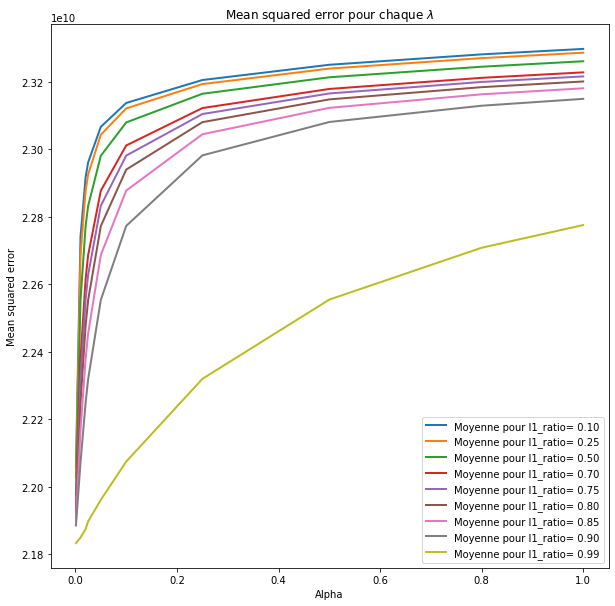

In [ ]:
# Insérez votre code ici 
alphas = model_encv.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_encv.mse_path_.shape[0]) :
    plt.plot(alphas, model_encv.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_encv.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

### 8- d  Afficahge des hyperparamètres choisis par validation croisée 

In [ ]:
print(model_encv.alpha_)
print(model_encv.l1_ratio_)

0.001
0.99


 - le paramètre α choisis par le model égale  0.01
 
 - le paramètre λ choisis par le model égale 0.99

### 8-e Observation des résidus

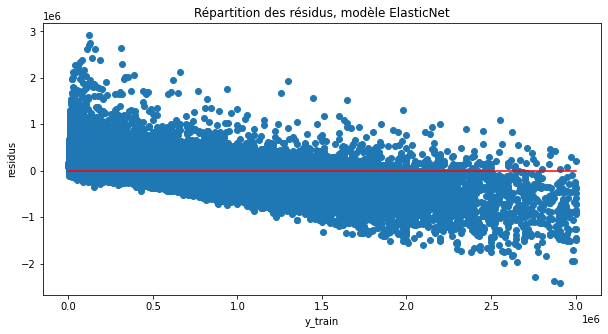

In [ ]:
residus = pred_train- y_train
plt.figure( figsize= (10, 5) )
plt.scatter(y_train, residus)
plt.plot([0, max(y_train)], [0, 0], c="r")
plt.xlabel("y_train")
plt.ylabel("residus")
plt.title("Répartition des résidus, modèle ElasticNet");

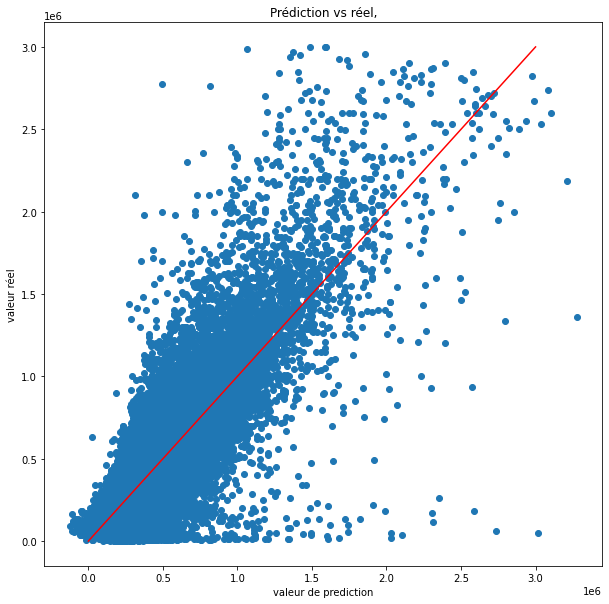

In [ ]:
#Prédiction vs réel:
plt.figure( figsize= (10, 10) )
plt.scatter(pred_test, y_test)
plt.plot([0, 3000000], [0, 3000000], c="r")
plt.xlabel("valeur de prediction")
plt.ylabel("valeur réel")
plt.title("Prédiction vs réel,");

Nous remarquons une forme de linéarité entre les valeurs de prédiction et les valeurs réelles, cependant cette linéarité reste très dispersée, notamment pour les prix très élevés 

## Conclusion:  

un  score de 
 
- train_set Score : 0.7386784400463458

- test_set Score  : 0.7422812345460255

est obetenu 

L'application de model ElasticNet sur nos données a pemis d'avoir un score aux alentour 74 % avec un legère  overfiting entre train_set et test_set  

le RMSE 
- RSME train_set : 148486.1487509462 

- RMSE test_set  : 146287.34129065787




une première modélisation  permet d'avoir des résultats acceptables mais en dessous de l'objectif. 

les données  de localisation disponibles ne sont pas encore directement utilisables, la prochaine étape consistera à construire des représentations ou des transformations des données de localisation d'origine.

L'application des connaissances de domaine supplémentaires aux informations brutes afin de les structurer d'une manière significative pour notre modèle, en partant sur le principe que  les choses qui sont proches les unes des autres sont souvent liées 


